In [1]:
%load_ext autoreload
%autoreload 2

import ccxt
import time
import matplotlib.pyplot as plt

In [2]:
# mlflowの設定
import mlflow

mlflow.set_tracking_uri('http://mlflow:8890')
mlflow.set_experiment('crypto_portfolio_bot')

# 実験のパラメータ
experiment_options = {
    'backtest_from': '2020-01-01 00:00:00+00',
    'backtest_to': '2023-01-01 00:00:00+00',
    'objective_type': 'max_quadratic_utility',
    'objective_param': 1.0,
    'download_timebar': False,
    'calculate_topx': False,
    'l2_reg': True,
    'l2_reg_gamma': 0.02,
    'weight_upper_bound': 1,            # 1銘柄のポジション / 全ポジションの絶対値の合計の最大値
    'weight_lower_bound': -1,           # 1銘柄のポジション / 全ポジションの絶対値の合計の最小値
    'rebalance_interval': 2*60*60,      # ポートフォリオリバランス間隔 [秒]
    'execution_period': 1.5*60*60,      # ポートフォリオリバランス実行期間 [秒]
    'timebar_interval': 5*60,           # タイムバー間隔 [秒]
    'weight_calc_period': 30*24*60*60,  # ポートフォリオ計算時のリターン系列の長さ [秒]
    'execution_cost': 0.001,            # トレード手数料
    'initial_usdt_value': 10000.0       # ポートフォリオ計算開始時のUSDT残高
}

mlflow.end_run()
mlflow.log_dict(experiment_options, 'experiment_options.json')

for _idx, _value in enumerate(experiment_options):
    print(f'{_value}: {experiment_options[_value]}')
    mlflow.log_param(_value, experiment_options[_value])

backtest_from: 2020-01-01 00:00:00+00
backtest_to: 2023-01-01 00:00:00+00
objective_type: max_quadratic_utility
objective_param: 1.0
download_timebar: False
calculate_topx: False
l2_reg: True
l2_reg_gamma: 0.02
weight_upper_bound: 1
weight_lower_bound: -1
rebalance_interval: 7200
execution_period: 5400.0
timebar_interval: 300
weight_calc_period: 2592000
execution_cost: 0.001
initial_usdt_value: 10000.0


In [3]:
# 時間足データを保存する時に使うTimescaleDB用のユーティリティライブラリの設定

import os
from timescaledb_util import *

pg_config = {
    'user': os.environ['POSTGRES_USER'],
    'password': os.environ['POSTGRES_PASSWORD'],
    'host': os.environ['POSTGRES_HOST'],
    'port': os.environ['POSTGRES_PORT'],
    'database': os.environ['POSTGRES_DATABASE_OHLCV_TRADES']
}

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
dbutil = TimeScaleDBUtil(user = pg_config['user'], password = pg_config['password'], host = pg_config['host'], port = pg_config['port'], database = pg_config['database'])

In [4]:
from decimal import Decimal
from datetime import timezone, datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option("display.max_rows", 50)
pd.set_option("display.min_rows", 50)

# タイムバーをダウンロードしてTimescaleDBに保存する関数、所定のdict型の配列でダウンロード対象を指定する
def download_timebar(targets):
    for target in targets:
        _exchange = target['exchange']
        _ccxt_client = getattr(ccxt, _exchange)()
        _ccxt_client.load_markets()

        _symbol = target['symbol']
        _interval = target['interval']
        
        since = int(time.mktime(datetime.strptime('2019-01-01 00:00:00+0000', '%Y-%m-%d %H:%M:%S%z').timetuple()) * 1000)

        dbutil.init_timebar_table(_exchange, _symbol, _interval)
        table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)

        df = dbutil.get_latest_timebar(_exchange, _symbol, _interval)
        if type(df) != type(None):
            latest_datetime = df['datetime']
            latest_timestamp = int(latest_datetime.timestamp() * 1000) + 1

            if latest_timestamp > since:
                since = latest_timestamp

        till = int(datetime.now(tz = timezone.utc).timestamp() * 1000)
        origin = since

        with tqdm(total = int(till - origin), initial=0) as _pbar:
            _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: 0')
            while since <= till:
                time.sleep(ccxt_client.rateLimit / 1000)

                result = ccxt_client.fetch_ohlcv(_symbol, _interval, since = int(since), limit = 1000) # 5min

                df = pd.DataFrame.from_dict(result, dtype=str)
                if len(df) == 0:
                    break

                _to_decimal = lambda x: Decimal(x)

                df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']
                df['datetime'] = df['datetime'].apply(lambda x: datetime.fromtimestamp(float(x) / 1000, tz = timezone.utc))
                df['datetime_from'] = df['datetime'] - timedelta(seconds=300) - timedelta(microseconds=1)
                df['open'] = df['open'].apply(_to_decimal)
                df['high'] = df['high'].apply(_to_decimal)
                df['low'] = df['low'].apply(_to_decimal)
                df['close'] = df['close'].apply(_to_decimal)
                df['volume'] = df['volume'].apply(_to_decimal)

                nan_columns = ['id', 'id_from', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum', 'dollar_buy_cumsum', 'dollar_sell_cumsum']
                for column in nan_columns:
                    df[column] = Decimal(0)

                ret = dbutil.df_to_sql(df=df, schema = table_name, if_exists = 'append')

                since = int(df.iloc[-1]['datetime'].timestamp()*1000) + 1
                _pbar.n = since - origin
                _pbar.set_postfix_str(f'{_exchange}, {_symbol}, {_interval}, row_counts: {len(df)}')
                _pbar.refresh()
            
            _pbar.n = int(till - origin)
            _pbar.refresh()            

In [5]:
# CCXTのクライアントを作り、無期限先物市場の5分足情報をTimescaleDBに書き込む

if experiment_options['download_timebar'] == True:
    # USDT建ての無期限先物を時間足ダウンロードの対象として設定する
    ccxt_client = getattr(ccxt, 'binanceusdm')()
    ccxt_client.load_markets()

    targets = []
    for symbol in ccxt_client.symbols:
        if '/USDT' in symbol:
            target_5m = {
                'exchange': 'binanceusdm',
                'symbol': symbol,
                'interval': f'{experiment_options["timebar_interval"]/60:.0f}m'
            }
            targets.append(target_5m)

    # USDT建ての無期限先物の5分足をTimescaleDBにダウンロードする
    download_timebar(targets)

In [6]:
# ダウンロードした無期限先物の直近50000本分の取引ボリュームを概算する

if experiment_options['calculate_topx'] == True:
    result = []
    row_counts = 0

    with tqdm(total = len(targets), initial=0) as _pbar:
        for target in targets:
            _exchange = target['exchange']
            _symbol = target['symbol']
            _interval = target['interval']

            table_name = dbutil.get_timebar_table_name(_exchange, _symbol, _interval)
            df = dbutil.read_sql_query(f'SELECT open, close, volume from "{table_name}"')
            recent_dollar_volume = (df.iloc[-50000:]['volume'] * (df.iloc[-50000:]['close'] + df.iloc[-50000:]['open']) / 2).sum()
            result.append({'symbol': _symbol, 'rows': len(df), 'recent_dollar_volume': recent_dollar_volume})

            row_counts = row_counts + len(df)
            _pbar.n = _pbar.n + 1
            _pbar.set_postfix_str(f'{_symbol}, row_counts: {row_counts:,}, recent_dollar_volume: {recent_dollar_volume:,}')
            _pbar.refresh()

    df_recent_volume = pd.DataFrame(result)
    
    # 取引ボリューム概算結果を表示する
    df_recent_volume = df_recent_volume.sort_values('recent_dollar_volume', ascending=False)
    df_recent_volume['listed_days'] = df_recent_volume['rows']*5/60/24
    df_recent_volume = df_recent_volume.reset_index(drop=True)
    display(df_recent_volume[df_recent_volume['listed_days'] > 250])
    
    # 取引ボリューム概算が大きい順に10銘柄でポートフォリオの挙動をテストする
    portfolio_symbols = df_recent_volume[df_recent_volume['listed_days'] > 250].iloc[:10]['symbol']
else:
    portfolio_symbols = ['BTC/USDT', 'ETH/USDT', '1000SHIB/USDT', 'SOL/USDT', 'SAND/USDT', 'LUNA/USDT', 'FTM/USDT', 'XRP/USDT', 'ADA/USDT', 'AVAX/USDT']

portfolio_symbols.append('USDT/USDT')
print(f'Target symbols are {portfolio_symbols}')

Target symbols are ['BTC/USDT', 'ETH/USDT', '1000SHIB/USDT', 'SOL/USDT', 'SAND/USDT', 'LUNA/USDT', 'FTM/USDT', 'XRP/USDT', 'ADA/USDT', 'AVAX/USDT', 'USDT/USDT']


In [7]:
import talib

# ポートフォリオ構成銘柄の価格系列などを準備する
dfs = []
for _symbol in tqdm(portfolio_symbols):
    _table_name = dbutil.get_timebar_table_name('binanceusdm', _symbol, '5m')
    if _symbol == 'USDT/USDT':
        _table_name = dbutil.get_timebar_table_name('binanceusdm', 'BTC/USDT', '5m')
    
    _sql = f'SELECT datetime, close from "{_table_name}" WHERE datetime BETWEEN \'{experiment_options["backtest_from"]}\' AND \'{experiment_options["backtest_to"]}\' ORDER BY datetime ASC'
    _df = dbutil.read_sql_query(_sql, index_column = '')
    if len(_df) > 0:
        _df.loc[:, 'symbol'] = _symbol
        if _symbol == 'USDT/USDT':
            _df.loc[:, 'close'] = 1.0
        _df.dropna(inplace = True)
        dfs.append(_df)

df_portfolio = pd.concat(dfs).set_index(['datetime', 'symbol']).sort_index()

# ウェイト、ポジション、USDTバリュー列を準備する (後々ffillをして埋めるので、0で埋めてはいけない)
df_portfolio['target_weight'] = np.nan
df_portfolio['position'] = np.nan
df_portfolio['value'] = np.nan

100%|██████████| 11/11 [00:12<00:00,  1.17s/it]


In [8]:
# PyPortfolioOptを利用してポートフォリオウェイトを計算

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import plotting

import cvxpy as cp

COV_LENGTH = int(experiment_options['weight_calc_period'] / experiment_options['timebar_interval'])
df_weight_calc = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close')
array_performance = []

for i in tqdm(range(df_weight_calc.shape[0])):
    # リバランスの時間でだけポートフォリオのウェイトを計算する
    if (df_weight_calc.index[i].value // 10**9) % experiment_options['rebalance_interval'] == 0:
        # ポートフォリオ計算に必要なリターン系列の長さがない場合は、USDT 100%の初期ウェイトを維持する
        if i + 1 < COV_LENGTH:
            df_portfolio.loc[(df_weight_calc.index[i], slice(None)), 'target_weight'] = 0
            df_portfolio.loc[(df_weight_calc.index[i], 'USDT/USDT'), 'target_weight'] = 1
            continue

        _df_cov = df_weight_calc.iloc[max(0, i - COV_LENGTH + 1):i + 1].dropna(axis=1)
                
        # ここよりPyPortfolioOptによるポートフォリオウェイト計算
        _mu = mean_historical_return(_df_cov)
        _S = CovarianceShrinkage(_df_cov).ledoit_wolf()
        _ef = EfficientFrontier(_mu, _S, weight_bounds = (experiment_options['weight_lower_bound'], experiment_options['weight_upper_bound']))
        if experiment_options['l2_reg'] == True:
            _ef.add_objective(objective_functions.L2_reg, gamma=experiment_options['l2_reg_gamma']) # L2正則化を入れてひとつの銘柄にウェイトが集中するのを防ぐ
        
        # メモ : 負のポジションを許し、ポジションの絶対値の合計を1以下にするためにpyportfoliooptの_make_weight_sum_constraint関数に変更を加えている
        #def _make_weight_sum_constraint(self, is_market_neutral):
        #    ...
        #    else:
        #        # Check negative bound
        #        negative_possible = np.any(self._lower_bounds < 0)
        #        if negative_possible:
        #            # Use norm1 as position constraint
        #            self.add_constraint(lambda w: cp.sum(cp.abs(w)) <= 1)
        #        else: 
        #            self.add_constraint(lambda w: cp.sum(w) == 1)
        #    self._market_neutral = is_market_neutral
        
        # 目標ウェイトを計算する
        if experiment_options['objective_type'] == 'max_quadratic_utility':
            _weights = _ef.max_quadratic_utility(risk_aversion = experiment_options['objective_param'])
        elif experiment_options['objective_type'] == 'max_sharpe':
            _weights = _ef.max_sharpe()
        elif experiment_options['objective_type'] == 'min_volatility':
            _weights = _ef.min_volatility()
        elif experiment_options['objective_type'] == 'efficient_risk':
            _weights = _ef.efficient_risk(target_volatility = experiment_options['objective_param'])
        
        # ポートフォリオパフォーマンスを記録する
        _return, _volatility, _sharpe = _ef.portfolio_performance()
        array_performance.append([df_weight_calc.index[i], _return, _volatility, _sharpe])
        
        # 目標ウェイトを書き込み
        df_portfolio.loc[(df_weight_calc.index[i], slice(None)), 'target_weight'] = 0
        _cleaned_weights = _ef.clean_weights()
        for _key, _value in _cleaned_weights.items():
            df_portfolio.loc[(df_weight_calc.index[i], _key), 'target_weight'] = _value
        
        # 目標ウェイトを合計して1にならない場合があるので、補正を行う
        _target_weights = df_portfolio.loc[(df_weight_calc.index[i], slice(None)), 'target_weight']
        df_portfolio.loc[(df_weight_calc.index[i], slice(None)), 'target_weight'] = _target_weights / _target_weights.abs().sum()
            
# リバランスタイミングの間にある行の目標ウェイトをffillで埋める
_df_weight_calc = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='target_weight')
_df_weight_calc.fillna(method='ffill', inplace=True)
df_portfolio['target_weight'] = _df_weight_calc.stack()
df_portfolio = df_portfolio.sort_index().fillna(0)

100%|██████████| 229110/229110 [10:14<00:00, 373.01it/s]


In [9]:
# 初期ウェイトと初期ポジションをセットする
df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'target_weight'] = 0.0
df_portfolio.loc[(df_portfolio.index[0], 'USDT/USDT'), 'target_weight'] = 1.0
df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'value'] = df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'target_weight'] * experiment_options['initial_usdt_value']
df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'position'] = df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'target_weight'] * experiment_options['initial_usdt_value'] / df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'close']

/tmp/ipykernel_2002607/2992195766.py:2: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_portfolio.loc[(df_portfolio.index[0], slice(None)), 'target_weight'] = 0.0
/tmp/ipykernel_2002607/2992195766.py:3: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_portfolio.loc[(df_portfolio.index[0], 'USDT/USDT'), 'target_weight'] = 1.0
/tmp/ipykernel_2002607/2992195766.py:4: FutureWarning: The behavior of indexing on a MultiIndex with a nested 

In [10]:
# 5分足でのリバランス処理の計算を行う

# 各種ピボットテーブルを準備
_df_target_weight = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='target_weight').fillna(0)
_df_close = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close').fillna(0)
_df_position = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='position').fillna(0).copy()
_df_value = df_portfolio.reset_index().pivot(index = 'datetime', columns = 'symbol', values='value').fillna(0).copy()

# リバランスサイクル、執行期間などの定数を5分足何本分かで計算しておく
_rows_execution = int(experiment_options['execution_period'] / experiment_options['timebar_interval'])
_rows_rebalance = int(experiment_options['rebalance_interval'] / experiment_options['timebar_interval'])
_rows_wait_for_execution = _rows_rebalance - _rows_execution

for i in tqdm(range(1, _df_target_weight.shape[0], 1)):
    _step_in_rebalance_cycle = _df_target_weight.index[i].value // 10**9 // experiment_options['timebar_interval'] %_rows_rebalance
    
    # リバランス前のウェイトを求める
    _value_before_rebalance = (_df_position.iloc[i-1] * _df_close.iloc[i]).fillna(0)
    _value_before_rebalance_sum = _value_before_rebalance.abs().sum()
    _weight_before_rebalance = _value_before_rebalance / _value_before_rebalance_sum
    
    if _step_in_rebalance_cycle >= _rows_wait_for_execution:
        # リバランスサイクルの中の執行期間に入っていたらリバランス後のウェイトを求める
        _weight_after_rebalance = _weight_before_rebalance + (_df_target_weight.iloc[i] - _weight_before_rebalance) / (_rows_rebalance - _step_in_rebalance_cycle) # 1/残りリバランス回数に分割してvalueを調整していく
        
        # リバランス後のウェイトの合計が1にならない場合があるので補正しておく
        _weight_after_rebalance = _weight_after_rebalance / _weight_after_rebalance.abs().sum()
        
        # リバランス前と後のウェイトの差を計算する
        _weight_diff_abs_sum = (_weight_after_rebalance - _weight_before_rebalance).abs().sum()
        _value_after_rebalance_sum = _value_before_rebalance_sum * (1 - _weight_diff_abs_sum * experiment_options['execution_cost'])
        
        # ポジションの更新
        _value_after_rebalance_after_fee = _value_after_rebalance_sum * _weight_after_rebalance
        
        # 手数料がある場合、リバランス前後でポートフォリオの価値が増えているか同じなら警告する
        if _weight_diff_abs_sum > 0 and _value_after_rebalance_after_fee.abs().sum() >= _value_before_rebalance.abs().sum():
            print(f'fee warning! at {_df_value.index[i]}')
            print(f'_weight_diff.abs().sum() : {_weight_diff_abs_sum}')
            print(f'_value_after_rebalance_after_fee.abs().sum() : {_value_after_rebalance_after_fee.abs().sum()}')
            print(f'_value_before_rebalance.abs().sum() : {_value_before_rebalance.abs().sum()}')
            print(f'_weight_diff.abs()\n{(_weight_after_rebalance - _weight_before_rebalance).abs()}')

        # 手数料チェック
        #if _weight_diff_abs_sum > 0:
        #    print(f'fee is positive at {_df_value.index[i]}')
        #    print(f'_weight_diff.abs().sum() : {_weight_diff_abs_sum}')
        #    print(f'_value_after_rebalance_after_fee.abs().sum() : {_value_after_rebalance_after_fee.abs().sum()}')
        #    print(f'_value_before_rebalance.abs().sum() : {_value_before_rebalance.abs().sum()}')
        #    print(f'_weight_diff.abs()\n{(_weight_after_rebalance - _weight_before_rebalance).abs()}')

        _df_value.iloc[i] = _value_after_rebalance_after_fee
        
        _df_value.iloc[i].fillna(0, inplace=True)
        _df_position.iloc[i] = _df_value.iloc[i] / _df_close.iloc[i]
        _df_position.iloc[i].fillna(0, inplace=True)
        
    else:
        # 直前のバリューを維持する
        _df_value.iloc[i] = _df_value.iloc[i-1]
        _df_position.iloc[i] = _df_position.iloc[i-1]

df_portfolio['position'] = _df_position.stack()
df_portfolio['value'] = _df_value.stack()
df_portfolio = df_portfolio.sort_index().fillna(0)

100%|██████████| 229109/229109 [08:58<00:00, 425.83it/s]


In [11]:
# パフォーマンス表示用の関数
def visualize_performance(df, array_performance, render_from, render_to, options):
    _fig, _ax = plt.subplots(4, 1, figsize=(12, 24), sharex=False)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    # 行のすべてのウェイトが0またはNaNの行を削除してウェイト用のDataFrameを完成させる
    _df_weight = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
    _df_weight = _df_weight.reset_index().pivot(index = 'datetime', columns = 'symbol', values='target_weight').dropna(how = 'all').fillna(0)
    _df_weight = _df_weight[render_from:render_to]
    _df_weight_positive = _df_weight[_df_weight >= 0].fillna(0)
    _df_weight_negative = _df_weight[_df_weight < 0].fillna(0)

    # ポートフォリオウェイトの描画
    _ax[0].stackplot(_df_weight_positive.index, _df_weight_positive.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_weight.columns)
    handle, label = _ax[0].get_legend_handles_labels()
    _ax[0].stackplot(_df_weight_negative.index, _df_weight_negative.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_weight.columns)
    _ax[0].grid(True)
    _ax[0].legend(handle, label, bbox_to_anchor=(1.2, 1))
    _ax[0].set_title(f'Portofolio allocation')

    # コストを考慮した銘柄リターン表示用のデータフレームを準備
    _df_value = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
    _df_value = _df_value.reset_index().pivot(index = 'datetime', columns = 'symbol', values='value').dropna(how = 'all').abs().fillna(0)
    _df_value = _df_value[render_from:render_to]
    
    _ax[1].stackplot(_df_value.index, _df_value.T, colors=('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'b', 'g', 'r'), labels=_df_value.columns)
    _ax[1].grid(True)
    _ax[1].legend(bbox_to_anchor=(1.2, 1))
    _ax[1].set_title('Portfolio value')
    
    # DD表示
    _df_value['total'] = _df_value.sum(axis=1)
    _df_value['dd_val'] = _df_value['total'].cummax() - _df_value['total']
    _dd_end = _df_value['dd_val'].idxmax()
    _dd_start = _df_value['total'].cummax()[:_dd_end].idxmax()
    _ax[1].plot(_df_value[_dd_start:_dd_end].index, _df_value[_dd_start:_dd_end]['total'], color='r', scalex=False, scaley=False)
    _dd_dict = { 'start': _dd_start.strftime("%m/%d/%Y %H:%M:%S%z"), 'end': _dd_end.strftime("%m/%d/%Y %H:%M:%S%z"), 'dd_value': _df_value.loc[_dd_end, 'dd_val'], 'dd_pct': 1 - (_df_value.loc[_dd_end,'total'] / _df_value.loc[_dd_start, 'total']) }
    mlflow.log_dict(_dd_dict, 'drawdown.json')
    print(f"Max DD info: From {_dd_dict['start']} to {_dd_dict['end']}. DD value: {_dd_dict['dd_value']:.02f} USDT ({_dd_dict['dd_pct']*100:.02f}%)")
    
    # クローズ系列の描画
    _df_close = df.loc[(df.index.get_level_values('datetime').astype(np.int64) // 10**9 % options['rebalance_interval'] == 0), :]
    _df_close = _df_close.reset_index().pivot(index = 'datetime', columns = 'symbol', values='close').dropna(how = 'all').fillna(0)
    _df_close = _df_close[render_from:render_to]
    _df_close = _df_close / _df_close.iloc[0]
    _df_close.plot(ax=_ax[2])
    _ax[2].grid(True)
    _ax[2].set_title(f'Asset price')
    _ax[2].legend(bbox_to_anchor=(1.2, 1))

    # ポートフォリオ自体のパフォーマンス表示用のデータフレームを準備
    _df_portfolio_performance = pd.DataFrame(array_performance, columns=['datetime', 'return', 'volatility', 'sharpe']).set_index('datetime', drop = True)

    # ポートフォリオ自体のパフォーマンス描画
    _df_portfolio_performance[render_from:render_to]['return'].plot(ax=_ax[3], label='return')
    _df_portfolio_performance[render_from:render_to]['volatility'].plot(ax=_ax[3], label='volatility')
    _ax[3].grid(True)
    _ax_sub = _ax[3].twinx()
    _ax_sub.set_ylabel('sharpe')
    _df_portfolio_performance[render_from:render_to]['sharpe'].plot(ax=_ax_sub, style='r-', label='sharpe')
    _ax[3].set_title(f'Portofolio performance')
    _ax[3].set_ylabel('return / vol')
    _handle, _label = _ax[3].get_legend_handles_labels()
    _handle2, _label2 = _ax_sub.get_legend_handles_labels()
    _ax[3].legend(_handle + _handle2, _label + _label2, bbox_to_anchor=(1.2, 1))
    
    mlflow.log_figure(_fig, f'portofolio_{render_from}_to_{render_to}.png')
    return _fig

In [12]:
# パフォーマンスを表示
df_portfolio = df_portfolio.sort_index()
df_portfolio.fillna(0, inplace=True)

Max DD info: From 08/17/2020 18:00:00+0000 to 11/04/2020 16:00:00+0000. DD value: 10895.55 USDT (50.05%)


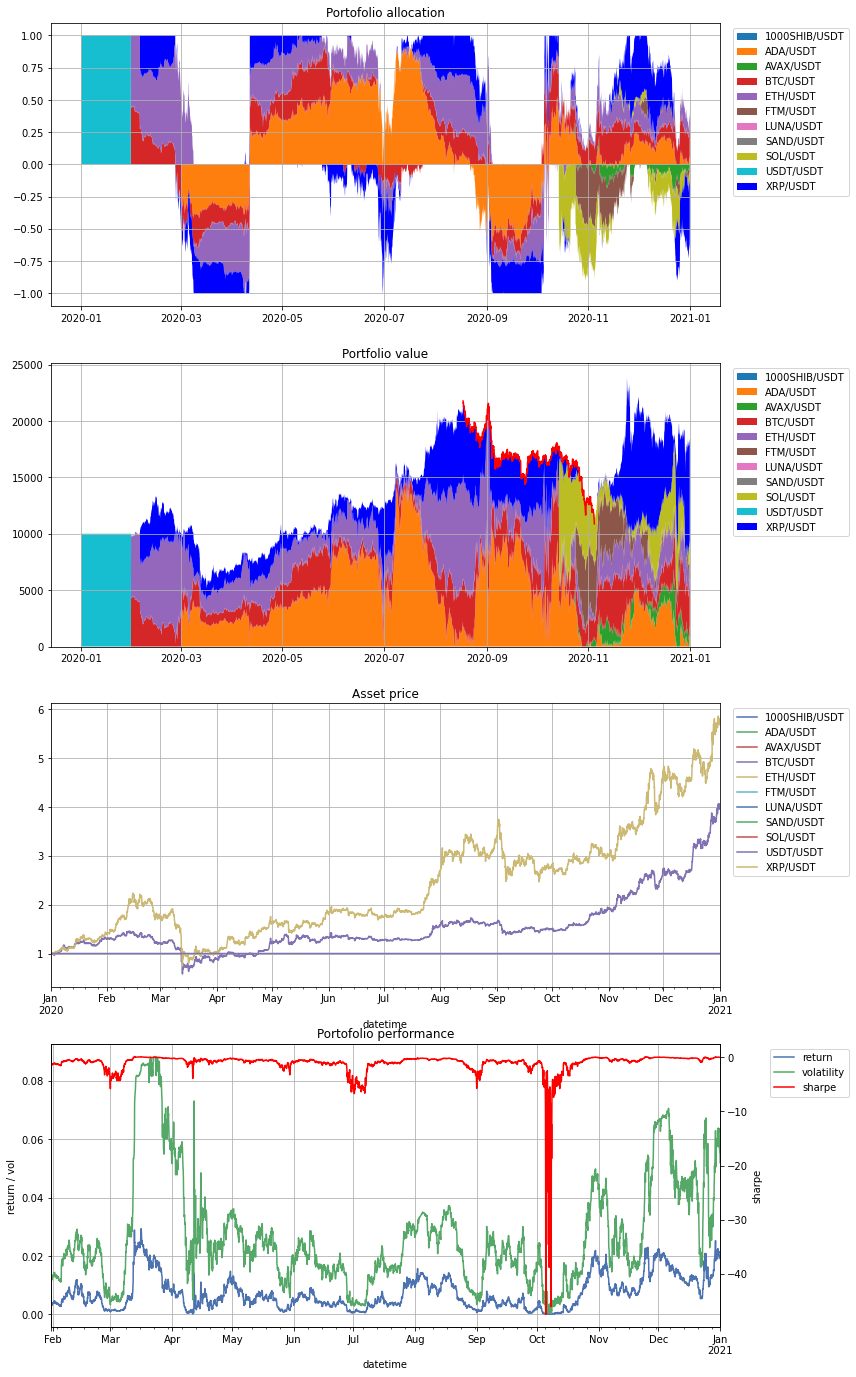

In [13]:
visualize_performance(df_portfolio, array_performance, '2020-01-01 00:00:00+00', '2021-01-01 00:00:00+00', experiment_options).show()

Max DD info: From 11/25/2021 06:00:00+0000 to 12/15/2021 16:00:00+0000. DD value: 3355465.38 USDT (41.11%)


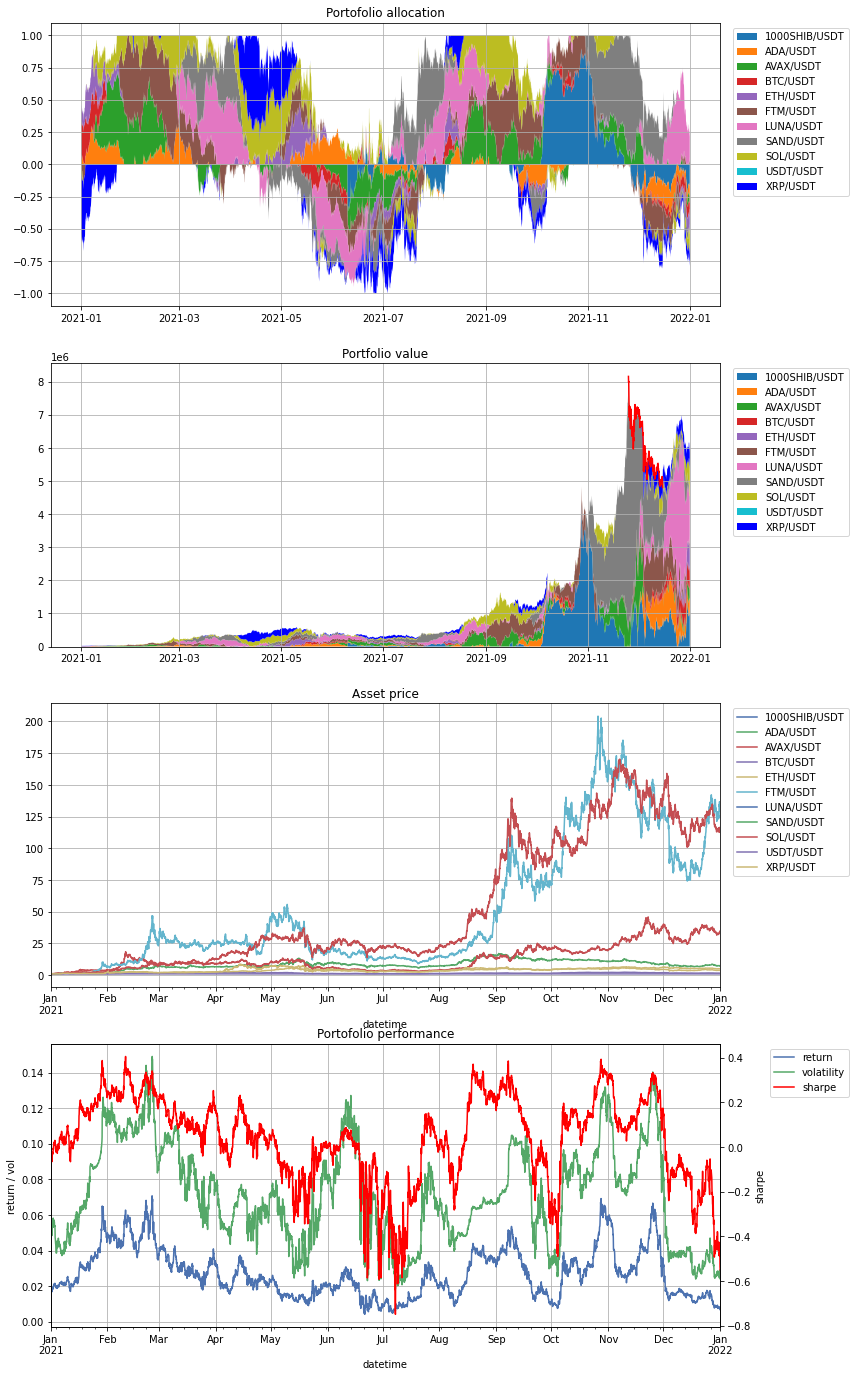

In [14]:
visualize_performance(df_portfolio, array_performance, '2021-01-01 00:00:00+00', '2022-01-01 00:00:00+00', experiment_options).show()

Max DD info: From 01/05/2022 10:00:00+0000 to 01/24/2022 14:00:00+0000. DD value: 2857906.93 USDT (43.19%)


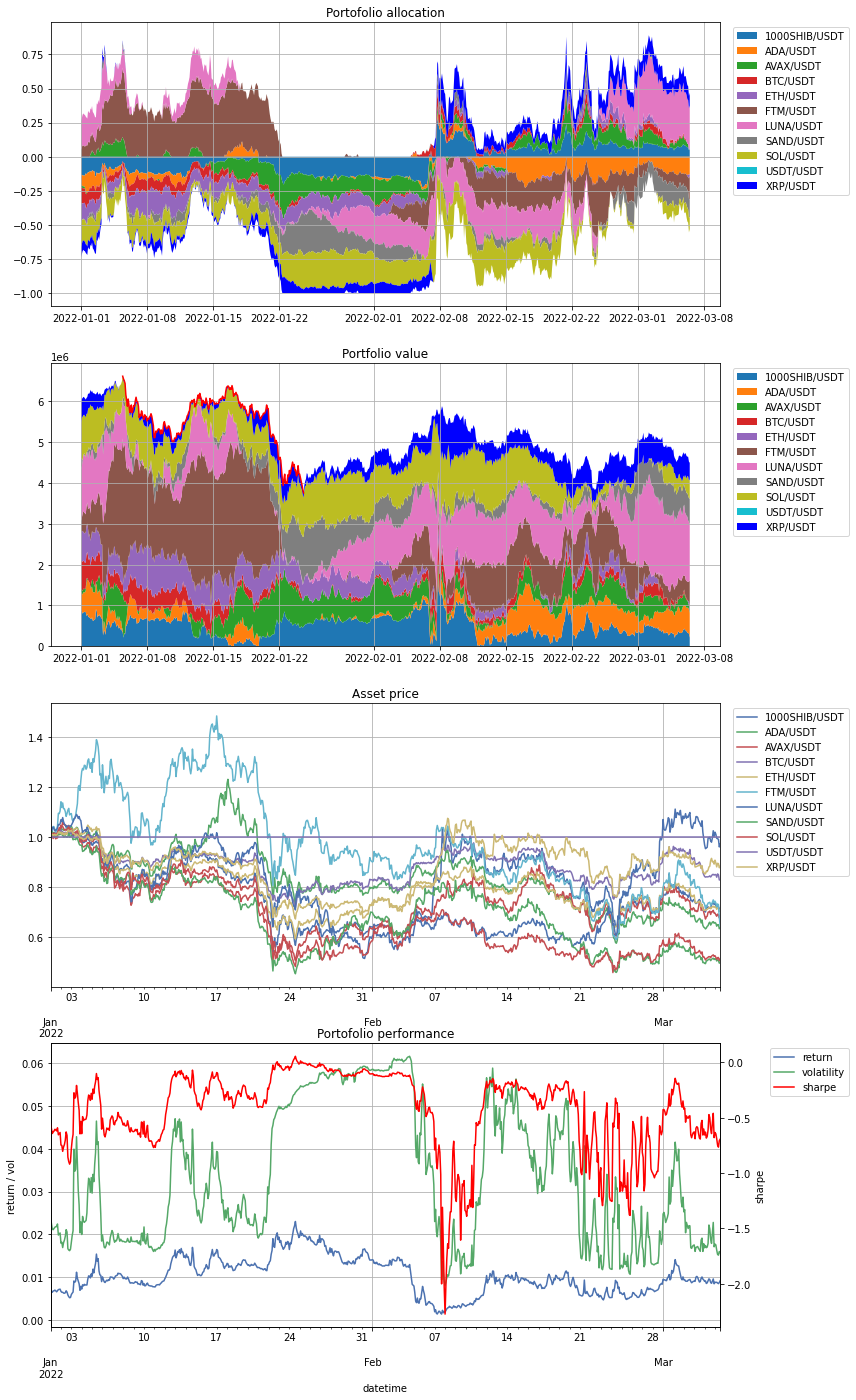

In [15]:
visualize_performance(df_portfolio, array_performance, '2022-01-01 00:00:00+00', '2023-01-01 00:00:00+00', experiment_options).show()

Max DD info: From 11/25/2021 06:00:00+0000 to 01/24/2022 14:00:00+0000. DD value: 4402485.66 USDT (53.94%)


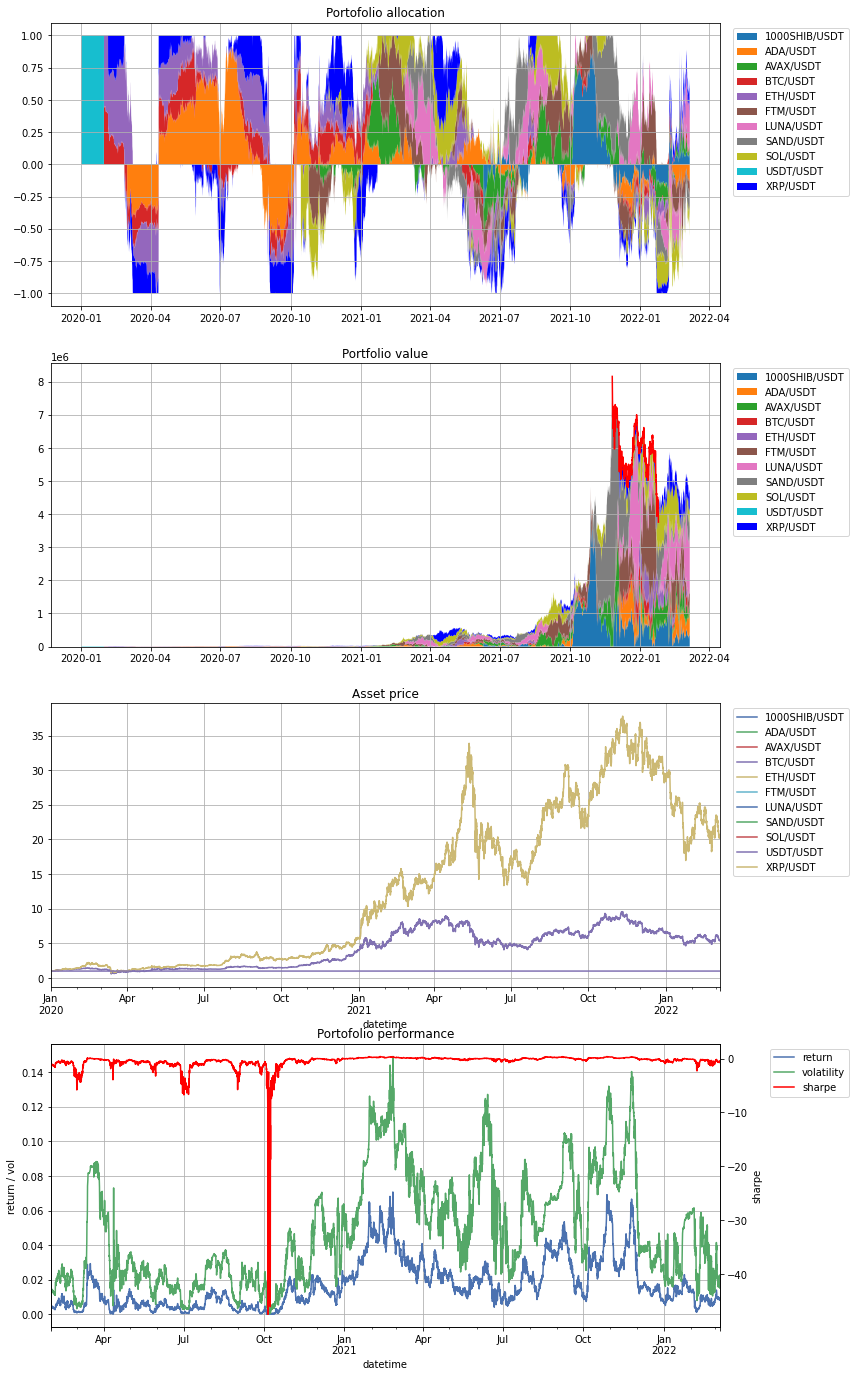

In [16]:
visualize_performance(df_portfolio, array_performance, '2020-01-01 00:00:00+00', '2023-01-01 00:00:00+00', experiment_options).show()

In [18]:
mlflow.end_run()